# **Diet Effectiveness Analysis**

By: Loh Zhi Shen

Last updated: 28 September 2022

---


**Summary**

* Analysed data collected to determine which diet was the most effective using analysis of variance techniques.

**Table of Contents:**

1. Imports
2. Introduction to the dataset and the problem
3. One Way Analysis of Variance
4. Two Way Analysis of Variance
5. One Way Analysis of Covariance
6. Two Way Analysis of Covariance



## **Imports**

In [63]:
# Data processing
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical methods
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.linear_model import LinearRegression

## **Introduction to the dataset and the problem**

***3 Diet Comparison Dataset*** 

The dataset consists of the gender, age, height, weight before and weight after and the diet type used of 90 individuals.

Link to dataset: https://www.kaggle.com/datasets/alexandercox1234/3-diet-comparison

**Problem**

Recently, I have been reading more into the mathematics of linear regression models. During my readings, I discovered the analysis of variance technique to check for model adequacy using the F-test. As such, this notebook serves as practice in applying the theoretical knowledge onto an actual dataset.

Therefore, the overall problem tacked within this notebook will be: 

1. Are the different diets the same in terms of effectiveness?
2. If they are not all the same, which diets are significantly different from one another?
3. And, what affects the outcome of the diet?

In [2]:
# reading in the data
raw = pd.read_csv('Diet_R.csv')
raw.head()

,Person,gender,Age,Height,pre.weight,Diet,weight6weeks
0,1,0,22,159,58,1,54.2
1,2,0,46,192,60,1,54.0
2,3,0,55,170,64,1,63.3
3,4,0,33,171,64,1,61.1
4,5,0,50,170,65,1,62.2


### **Data Cleaning**

The dataset has been cleaned prior to being posted online. As such, we will be simply checking if there are any null values within the dataset.

In [3]:
# display the dataset information
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Person        90 non-null     int64  
 1   gender        90 non-null     int64  
 2   Age           90 non-null     int64  
 3   Height        90 non-null     int64  
 4   pre.weight    90 non-null     int64  
 5   Diet          90 non-null     int64  
 6   weight6weeks  90 non-null     float64
dtypes: float64(1), int64(6)
memory usage: 5.0 KB


Since the number of non-null entries in each column is equal to the number of rows in the dataset, there are no null values which need to be filled in.

However, I noticed that the column names are a bit weird so I'll rename the different columns.

In [17]:
# renaming columns
raw = raw.rename({
    'gender': 'Gender',
    'pre.weight': 'Weight Before',
    'weight6weeks': 'Weight After'
}, axis = 1)

### **Exploratory Data Analysis**

**Univariate**

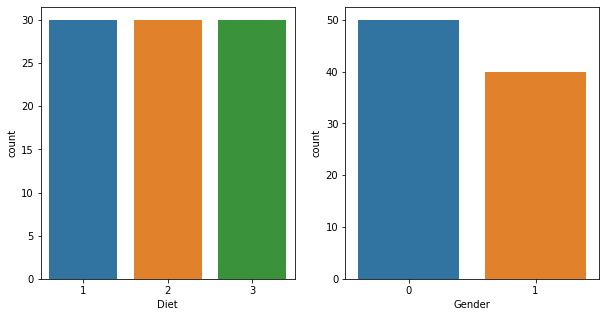

In [19]:
# count plots for categorical variables
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
sns.countplot(data = raw, x = 'Diet', ax = axes[0])
sns.countplot(data = raw, x = 'Gender', ax = axes[1])

It is interesting to see that there is a slight unbalance in the genders in the dataset.

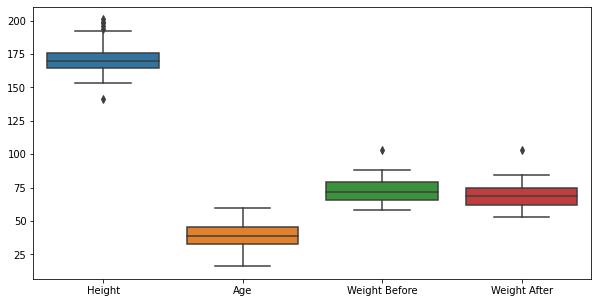

In [24]:
# boxplots for numeric columns
plt.figure(figsize = (10, 5))
sns.boxplot(data = raw[['Height', 'Age', 'Weight Before', 'Weight After']])

It appears that there are some really tall people in the data.

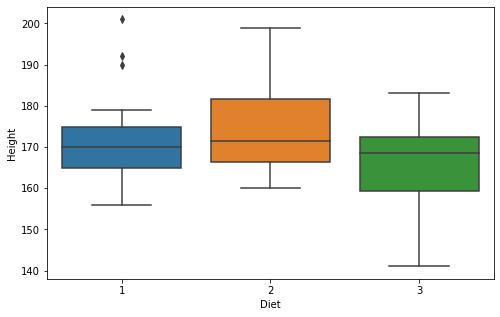

In [30]:
# checking heights within groups
plt.figure(figsize = (8, 5))
sns.boxplot(data = raw, y = 'Height', x = 'Diet')

It appears that these people are mainly grouped in Diet #1 and Diet #2

As such, the metric used to measure the effectiveness of the diet will be adjusted for height.

$BMI = {Weight} / {Height^2}$

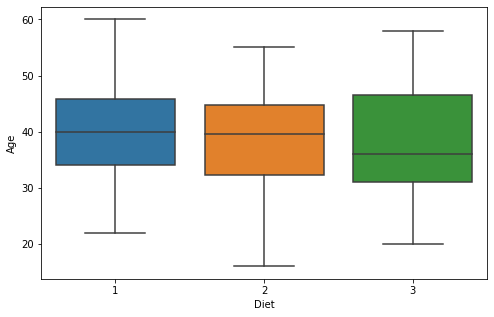

In [32]:
# checking age within groups
plt.figure(figsize = (8, 5))
sns.boxplot(data = raw, x = 'Diet', y = 'Age')

It appears that the ages within each group is pretty balanced.

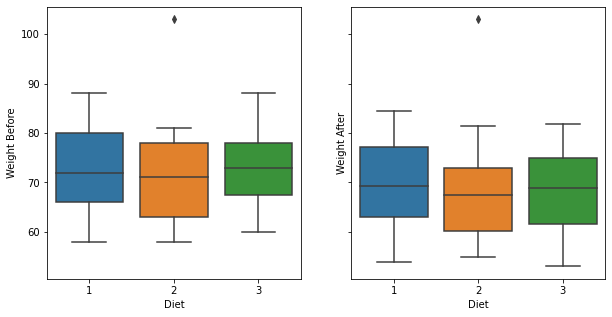

In [35]:
# checking weights within groups
fig, axes = plt.subplots(1 , 2, figsize = (10, 5), sharey = True)
sns.boxplot(data = raw, x = 'Diet', y = 'Weight Before', ax = axes[0])
sns.boxplot(data = raw, x = 'Diet', y = 'Weight After', ax = axes[1])

In [36]:
raw.loc[raw['Weight Before'] < raw['Weight After']]

,Person,Gender,Age,Height,Weight Before,Diet,Weight After
14,15,1,39,168,71,1,71.6
32,33,0,44,174,58,2,60.1
45,46,0,29,169,77,2,77.5
55,56,1,39,180,80,2,81.4


It appears that there are some individuals that gained weight using the diet which is interesting.

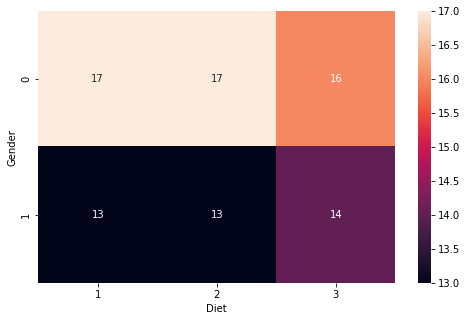

In [40]:
# counts within different groups
counts = raw.groupby(['Diet', 'Gender']).count()['Person'].unstack('Diet')
plt.figure(figsize = (8, 5))
sns.heatmap(data = counts, annot = True)

The different diets have approximately the same gender ratio.

### **Data Transformation**

As mentioned above, BMI will be the metric used to compare the diets.

In [42]:
# transform the data
df = raw.copy()
df['start_bmi'] = df['Weight Before'] / (df['Height'] / 100) ** 2
df['end_bmi'] = df['Weight After'] / (df['Height'] / 100) ** 2
df['delta_bmi'] = df['start_bmi'] - df['end_bmi']

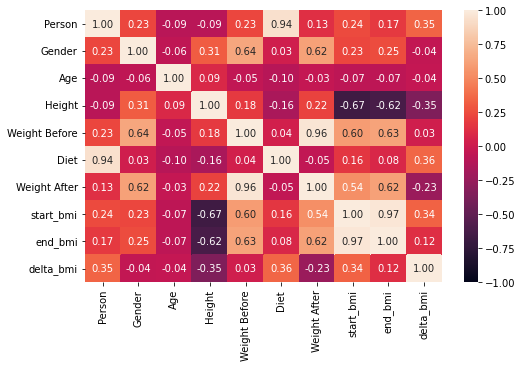

In [100]:
# correlation coefficients
plt.figure(figsize = (8, 5))
sns.heatmap(data = df.corr(), annot = True, fmt = '.2f', vmin = -1, vmax = 1)

## **One Way ANOVA**

In this scenario, we will assume that no other data besides the diet type and change is BMI is given.

Model: $y_i = µ + τ + e_i$, where $e_i$ ~ $N(0, σ^2)$ 

$µ$: overall mean response of k samples

$τ$: treatment effect i.e. the deviation of the group mean from the overall mean

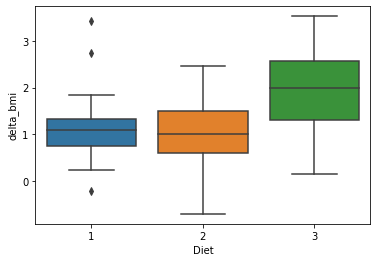

In [47]:
# data visualization
sns.boxplot(data = df, x = 'Diet', y = 'delta_bmi')

**F-test:**

$H_0: µ_1 = µ_2 = µ_3$

$H_1: µ_i ≠ µ_j$ for some $i ≠ j$

Significance level: 5%

In [48]:
# Create the ANOVA table
table = pd.DataFrame(columns = ['df', 'SS', 'MS', 'F'], index = ['Between groups', 'Within groups', 'Total'])

# Input degrees of freedom
n = len(df)
p = df['Diet'].nunique() - 1
table['df'] = [p, n - p - 1, n - 1]

# Calculate Sums of Squares
grand_mean = df['delta_bmi'].mean()
groupby = df.groupby(['Diet'])
SST = 0
SSE = 0
for i, values in groupby:
    group_count = len(values)
    group_mean = values['delta_bmi'].mean()
    SST += group_count * (group_mean - grand_mean) ** 2
    SSE += np.sum((values['delta_bmi'] - group_mean) ** 2)
Syy = np.sum((df['delta_bmi'] - grand_mean) ** 2)
assert Syy == SST + SSE
table['SS'] = [SST, SSE, Syy]

# Calculate Mean Squared
table['MS'] = table['SS'] / table['df']
table.loc['Total', 'MS'] = None

# Calculate F-statistic
table.loc['Between groups', 'F'] = table.loc['Between groups', 'MS'] / table.loc['Within groups', 'MS']

table

,df,SS,MS,F
Between groups,2,14.689575,7.344788,11.491246
Within groups,87,55.607243,0.639164,NaN
Total,89,70.296819,NaN,NaN


**Using statsmodels module**

In [49]:
# fit ols model 
lm = ols('delta_bmi ~ C(Diet)', data = df).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              delta_bmi   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     11.49
Date:                Wed, 28 Sep 2022   Prob (F-statistic):           3.73e-05
Time:                        01:19:07   Log-Likelihood:                -106.04
No. Observations:                  90   AIC:                             218.1
Df Residuals:                      87   BIC:                             225.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.1330      0.146      7.762   

In [50]:
# ANOVA Table
anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
C(Diet),2.0,14.689575,7.344788,11.491246,0.000037
Residual,87.0,55.607243,0.639164,NaN,NaN


**Analysis**

***Significance of diet type:***

Based on the annova table, it can be seen that $P(F(2,87) > 11.5) = 3.7e-5 < 0.05$. Therefore, the type of diet does affect the change in BMI very significantly.

**T-test**

$H_0: µ_a = µ_b$

$H_1: µ_a ≠ µ_b$

Significance level: 5%

In [51]:
# conduct t test
table = pd.DataFrame(columns = ['coefficient', 'standard error', 'T'], index = ['2-1', '3-1', '3-2'])

df_a = df.loc[df['Diet'] == 1, 'delta_bmi']
df_b = df.loc[df['Diet'] == 2, 'delta_bmi']
df_c = df.loc[df['Diet'] == 3, 'delta_bmi']

n_a = len(df_a)
n_b = len(df_b)
n_c = len(df_c)

pooled_std = np.sqrt(((n_a - 1) * df_a.var() + (n_b - 1) * df_b.var() + (n_c - 1) * df_c.var()) / (n_a + n_b + n_c - 3))

table.loc['2-1', 'coefficient'] = df_b.mean() - df_a.mean()
table.loc['3-1', 'coefficient'] = df_c.mean() - df_a.mean()
table.loc['3-2', 'coefficient'] = df_c.mean() - df_b.mean()

table.loc['2-1', 'standard error'] = pooled_std * (1/n_b + 1/n_a) ** 0.5
table.loc['3-1', 'standard error'] = pooled_std * (1/n_c + 1/n_b) ** 0.5
table.loc['3-2', 'standard error'] = pooled_std * (1/n_c + 1/n_b) ** 0.5

table['T'] = table['coefficient'] / table['standard error']

table

,coefficient,standard error,T
2-1,-0.148234,0.206424,-0.718102
3-1,0.773231,0.206424,3.745838
3-2,0.921465,0.206424,4.46394


**Using statsmodels**

In [52]:
# pair wise t test to test for significant difference
lm.t_test_pairwise('C(Diet)').result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
2-1,-0.148234,0.206424,-0.718102,0.474618,-0.558524,0.262057,0.474618,False
3-1,0.773231,0.206424,3.745838,0.000323,0.362941,1.183522,0.000645,True
3-2,0.921465,0.206424,4.463940,0.000024,0.511175,1.331755,0.000072,True


**Analysis**

***Difference between diet types:***

*T-Test 1: Diet #1 vs Diet #2*

$P(T > 0.718) = 0.475 > 0.05$ 

There is a significant difference between diet #1 and diet #2.

*T-Test 2: Diet #1 vs Diet #3*

$P(T > 3.746) = 3.2e-4 < 0.05$ 

There is a significant difference between diet #1 and diet #3.

*T-Test 3: Diet #2 vs Diet #3*

$P(T > 4.463) = 2.4e-5 < 0.05$ 

There is a significant difference between diet #2 and diet #3.

### **Conclusion**

There are **significant** difference between the 3 diets, with diet 3 being significantly different from diet 1 and diet 2.

**Diet 3** is the best in this case.

The decrease in BMI seen in the participants using diet 3 is significantly greater than the decrease seen in participants using diet 1 and diet 2. 

## **Two Way ANOVA**

In this scenario, we will assume that gender and diet type is given as well.

The model used for two way ANOVA is slightly more complicated than the model used in one way ANOVA.

Model: $y_i = µ + τ_a + τ_b + τ_{ab} + e_i$, where $e_i$ ~ $N(0, σ^2)$ 

$µ$: overall mean response of k samples

$τ_a$: treatment effect due to group A

$τ_b$: treatment effect due to group B

$τ_{ab}$: interaction effect 


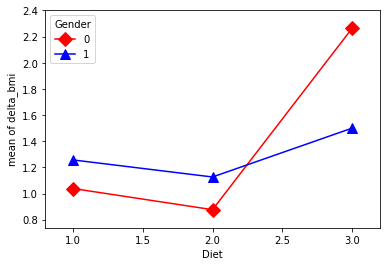

In [54]:
# visualize combined effect of gender and diet
fig = interaction_plot(df['Diet'], df['Gender'], df['delta_bmi'], 
                       colors = ["red", "blue"], markers = ["D", "^"], ms = 10)

Since the 2 curves are not parallel, there appears to be some level of interaction between the 2 factors.

**F-Test**

$H0: τ_{ab} = 0$

$H1 : τ_{ab} ≠ 0$

Significance level: 5%

In [55]:
# create ANOVA table
table = pd.DataFrame(columns = ['df', 'SS', 'MS', 'F'], index = ['Diet', 'Gender', 'Interaction', 'Error', 'Total'])

# calculate degrees of freedom
table.loc['Diet', 'df'] = df['Diet'].nunique() - 1
table.loc['Gender', 'df'] = df['Gender'].nunique() - 1
table.loc['Interaction', 'df'] = table.loc['Diet', 'df'] * table.loc['Gender', 'df']
table.loc['Total', 'df'] = len(df) - 1
table.loc['Error', 'df'] = table.loc['Total', 'df'] - table.loc['Interaction', 'df'] - table.loc['Gender', 'df'] - table.loc['Diet', 'df']

# calculate sums of squares
grand_mean = df['delta_bmi'].mean()
table.loc['Diet', 'SS'] = 0
for i, values in df.groupby('Diet')['delta_bmi']:
    table.loc['Diet', 'SS'] += (values.mean() - grand_mean) ** 2 * len(values)
table.loc['Gender', 'SS'] = 0
for i, values in df.groupby('Gender')['delta_bmi']:
    table.loc['Gender', 'SS'] += len(values) * (values.mean() - grand_mean) ** 2
table.loc['Error', 'SS'] = 0
for i, values in df.groupby(['Diet', 'Gender'])['delta_bmi']:
    table.loc['Error', 'SS'] += np.sum((values - values.mean()) ** 2)
table.loc['Total', 'SS'] = np.sum((df['delta_bmi'] - df['delta_bmi'].mean()) ** 2)
table.loc['Interaction', 'SS'] = table.loc['Total', 'SS'] - table.loc['Error', 'SS'] - table.loc['Gender', 'SS'] - table.loc['Diet', 'SS']

# calculate MS
table['MS'] = table['SS'] / table['df']
table.loc['Total', 'MS'] = None

# calculate F
table.loc['Diet', 'F'] = table.loc['Diet', 'MS'] / table.loc['Error', 'MS']
table.loc['Gender', 'F'] = table.loc['Gender', 'MS'] / table.loc['Error', 'MS']
table.loc['Interaction', 'F'] = table.loc['Interaction', 'MS'] / table.loc['Error', 'MS']

table

,df,SS,MS,F
Diet,2,14.689575,7.344788,12.227877
Gender,1,0.126302,0.126302,0.210273
Interaction,2,5.025562,2.512781,4.183372
Error,84,50.455378,0.600659,NaN
Total,89,70.296819,None,NaN


**Using statsmodels**

In [58]:
# Create linear models
lm_1 = ols('delta_bmi ~ C(Gender) * C(Diet)', data = df).fit()
lm_2 = ols('delta_bmi ~ C(Diet) * C(Gender)', data = df).fit()

In [59]:
# ANOVA Table
anova_lm(lm_1, typ = 1)

,df,sum_sq,mean_sq,F,PR(>F)
C(Gender),1.0,0.126302,0.126302,0.210273,0.647738
C(Diet),2.0,14.789336,7.394668,12.310920,0.000020
C(Gender):C(Diet),2.0,4.925801,2.462901,4.100329,0.019994
Residual,84.0,50.455378,0.600659,NaN,NaN


In [60]:
anova_lm(lm_2, typ = 1)

,df,sum_sq,mean_sq,F,PR(>F)
C(Diet),2.0,14.689575,7.344788,12.227877,0.000022
C(Gender),1.0,0.226063,0.226063,0.376359,0.541216
C(Diet):C(Gender),2.0,4.925801,2.462901,4.100329,0.019994
Residual,84.0,50.455378,0.600659,NaN,NaN


It is interesting to note that changing the order of terms in the equation changes the sums of squares given in the ANOVA table.

>Because of the sequential nature and the fact that the two main factors are tested in a particular order, this type of sums of squares will give different results for unbalanced data depending on which main effect is considered first.<br>
> Source: https://stats.stackexchange.com/questions/279459/output-of-aov-in-r-varies-with-changing-order-of-independent-variables


### **Conclusions**

Using the smaller of the 2 F values for the interaction, we can conclude the following:

$P(F(2, 84) > 4.10) = 0.019994 < 0.05$

There are significant interactions between type of diet and gender.

Since we have found significant interactions between type of diet and gender, there is no need to further test for significant effects of type and diet individually.

Again, we can conclude that the diets are significantly different, but the best diet depends on the gender.

## **One Way ANCOVA**

In this scenario, we will assume that data about age and diet is given.

**Disclaimer:**

I understand there is little correlation between age and change in bmi, but this is solely for practice.

Reduced model: $y_i = x_{i0} + x_{i1}β_1 + e_i$, where $e_i$ ~ $N(0,σ^2)$

Full model: $y_i = x_{i0} + x_{i1}β_1 + x_{i2}β_2 + x_{i3}β_3 + e_i$, where $e_i$ ~ $N(0,σ^2)$

$x_1$: Age

$x_2$ and $x_3$: one hot encoding for diet 

One thing to note is that 1 categorical variable encoding is dropped to prevent a singular matrix from being formed.

**F-test:**

$H_0: β_{q+1} = β_{q+2} = ... = β_{p} = 0$

$H_0: β_i ≠ β_j$ for some $i ≠ j$ where $q < i,j ≤ p$ 

Significance level: 5%

In [95]:
# Create ANOVA Table
table = pd.DataFrame(columns = ['df', 'SS', 'MS', 'F'], index = ['Regression', 'Extra', 'Residue', 'Total'])

# calculate degree of freedom
table.loc['Regression', 'df'] = 1
table.loc['Extra', 'df'] = df['Diet'].nunique() - 1
table.loc['Total', 'df'] = len(df) - 1
table.loc['Residue', 'df'] = table.loc['Total', 'df'] - table.loc['Regression', 'df'] - table.loc['Extra', 'df']

# calculate sums of squares
model = LinearRegression()
model.fit(df[['Age']].to_numpy(), df['delta_bmi'].to_numpy())
predictions = model.predict(df[['Age']].to_numpy())
grand_mean = df['delta_bmi'].mean()
table.loc['Regression', 'SS'] = np.sum((predictions - grand_mean) ** 2)

model = LinearRegression()
one_hot = pd.get_dummies(df['Diet']).iloc[:,:-1]
X = pd.concat([df[['Age']], one_hot], axis = 1).to_numpy()
model.fit(X, df['delta_bmi'].to_numpy())
predictions = model.predict(X)
table.loc['Extra', 'SS'] = np.sum((predictions - grand_mean) ** 2) - table.loc['Regression', 'SS']

table.loc['Total', 'SS'] = np.sum((df['delta_bmi'] - grand_mean) ** 2) 
table.loc['Residue', 'SS'] = table.loc['Total', 'SS'] - table.loc['Extra', 'SS'] - table.loc['Regression', 'SS']

# calculate Mean Squares
table['MS'] = table['SS'] / table['df']
table.loc['Total', 'MS'] = None

# calculate F
table.loc['Extra', 'F'] = table.loc['Extra', 'MS'] / table.loc['Residue', 'MS']

table

,df,SS,MS,F
Regression,1,0.090424,0.090424,NaN
Extra,2,14.599498,7.299749,11.289579
Residue,86,55.606896,0.646592,NaN
Total,89,70.296819,None,NaN


**Using statsmodels**

In [86]:
lm_3 = ols('delta_bmi ~ Age', data = df).fit()
lm_4 = ols('delta_bmi ~ Age + C(Diet)', data = df).fit()

In [89]:
anova_lm(lm_3, lm_4)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,88.0,70.206395,0.0,NaN,NaN,NaN
1,86.0,55.606896,2.0,14.599498,11.289579,0.000044


### **Conclusions**

$P(F > 11.29) = 0.000044 < 0.05$

Therefore, there is a significant relation between diet and change in bmi.

## **Two way ANCOVA**

In this scenario, we will assume that the age, gender and diet is given.

Reduced model: $y_i = x_{i0} + x_{i1}β_1 + x_{i2}β_2 + x_{i3}β_3 +  x_{i4}β_4 + e_i$, where $e_i$ ~ $N(0,σ^2)$

Full model: $y_i = x_{i0} + x_{i1}β_1 + x_{i2}β_2 + x_{i3}β_3 +  x_{i4}β_4 + x_{i2}x_{i4}β_5 + x_{i3}x_{i4}β_6 + e_i$, where $e_i$ ~ $N(0,σ^2)$

$x_{i1}$: Age

$x_{i2}$ and $x_{i3}$: Diet

$x_{i4}$: Gender

$x_{i2}x_{i4}$ and $x_{i3}x_{i4}$: Interaction effects

**F-Test**:

$H_0: x_{i2}x_{i4} = x_{i3}x_{i4} = 0$

$H_0: x_{ia}x_{ib} ≠ 0$ for some $2 ≤ a ≤ 3$ and $b == 4$

In [132]:
# Create ANOVA Table
table = pd.DataFrame(columns = ['df', 'SS', 'MS', 'F'], index = ['Regression', 'Diet', 'Gender', 'Interaction', 'Error', 'Total'])

# calculate degree of freedom
table.loc['Regression', 'df'] = 1
table.loc['Diet', 'df'] = df['Diet'].nunique() - 1 
table.loc['Gender', 'df'] = df['Gender'].nunique() - 1
table.loc['Interaction', 'df'] = table.loc['Diet', 'df'] * table.loc['Gender', 'df']
table.loc['Total', 'df'] = len(df) - 1
table.loc['Error', 'df'] = table.loc['Total', 'df'] - table.loc['Interaction', 'df'] - table.loc['Gender', 'df'] - table.loc['Diet', 'df'] - table.loc['Regression', 'df']

# calculate sums of squares
model = LinearRegression()
model.fit(df[['Age']].to_numpy(), df['delta_bmi'].to_numpy())
predictions = model.predict(df[['Age']].to_numpy())
grand_mean = df['delta_bmi'].mean()
table.loc['Regression', 'SS'] = np.sum((predictions - grand_mean) ** 2)

model = LinearRegression()
one_hot = pd.get_dummies(df['Diet']).iloc[:,:-1]
X = pd.concat([df[['Age']], one_hot], axis = 1).to_numpy()
model.fit(X, df['delta_bmi'].to_numpy())
predictions = model.predict(X)
table.loc['Diet', 'SS'] = np.sum((predictions - grand_mean) ** 2) - table.loc['Regression', 'SS']

model = LinearRegression()
one_hot_diet = pd.get_dummies(df['Diet']).iloc[:, :-1]
one_hot_gender = df['Gender']
X = pd.concat([df[['Age']], one_hot_diet, one_hot_gender], axis = 1).to_numpy()
model.fit(X, df['delta_bmi'].to_numpy())
predictions = model.predict(X)
table.loc['Gender', 'SS'] = np.sum((predictions - grand_mean) ** 2) - table.loc['Regression', 'SS'] - table.loc['Diet', 'SS']

model = LinearRegression()
one_hot_diet = pd.get_dummies(df['Diet']).iloc[:, :-1]
one_hot_gender = df['Gender']
one_hot_interactions = pd.DataFrame(one_hot_diet.to_numpy() * one_hot_gender.to_numpy().reshape((-1, 1)))
X = pd.concat([df[['Age']], one_hot_diet, one_hot_gender, one_hot_interactions], axis = 1).to_numpy()
model.fit(X, df['delta_bmi'].to_numpy())
predictions = model.predict(X)
table.loc['Interaction', 'SS'] = np.sum((predictions - grand_mean) ** 2) - table.loc['Regression', 'SS'] - table.loc['Diet', 'SS'] - table.loc['Gender', 'SS']

table.loc['Total', 'SS'] = np.sum((df['delta_bmi'] - grand_mean) ** 2)
table.loc['Error', 'SS'] = table.loc['Total', 'SS'] - table.loc['Regression', 'SS'] - table.loc['Diet', 'SS'] - table.loc['Gender', 'SS'] - table.loc['Interaction', 'SS']

# calculate means squares
table['MS'] = table['SS'] / table['df']
table.loc['Total', 'MS'] = None

# calculate F
table.loc['Diet', 'F'] = table.loc['Diet', 'MS'] / table.loc['Error', 'MS']
table.loc['Gender', 'F'] = table.loc['Gender', 'MS'] / table.loc['Error', 'MS']
table.loc['Interaction', 'F'] = table.loc['Interaction', 'MS'] / table.loc['Error', 'MS']

table

,df,SS,MS,F
Regression,1,0.090424,0.090424,NaN
Diet,2,14.599498,7.299749,12.012931
Gender,1,0.225761,0.225761,0.371527
Interaction,2,4.945551,2.472776,4.069357
Error,83,50.435584,0.607658,NaN
Total,89,70.296819,None,NaN


**Using statsmodels**

In [105]:
lm_5 = ols('delta_bmi ~ Age + C(Diet) + C(Gender)', data = df).fit()
lm_6 = ols('delta_bmi ~ Age + C(Diet) * C(Gender)', data = df).fit()

In [106]:
anova_lm(lm_5, lm_6)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,85.0,55.381135,0.0,NaN,NaN,NaN
1,83.0,50.435584,2.0,4.945551,4.069357,0.02061


### **Conclusions**

$P(F > 4.069) = 0.02061 < 0.05$

There are significant interactions between type of diet and gender.